## Generate MOM6 Chlorophyll File from scratch using Seawifs Climatology

In [ ]:
# made with xgcm tools - had to install hct flood and also numba (from numba channel) - this environment can be found under misc/conda/
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf
from HCtFlood import kara as flood
import cftime

### Create our Seawifs Monthly Climatology Data File

We will grab Seawifs Climatology Data (1997-2010_ from the University of Delaware ORB Lab's [THREDDS server](http://basin.ceoe.udel.edu/thredds/dodsC/SEAWIFSDAILY9KM.nc.html) using `xarray` (thank you Matt Shatley for this wonderful dataset). Then, we will subset this global dataset to the rough domain of our grid. Finally, we will resample by month to create a monthly climatology.

In [2]:
# grab seawifs data from Udel thredds, subset to our domain, resample to make monthly climatology. Note that resampling will require some decent computation time.
# we only want Chlorophlyll, so we subset that variable as well

wifs = xr.open_dataset("http://basin.ceoe.udel.edu/thredds/dodsC/SEAWIFSDAILY9KM.nc").sel(lat=slice(0,70), lon=slice(-100,-30))
wifs = wifs['chlor_a']
wifs_mon = wifs.groupby('time.month').mean('time')
wifs_mon.to_netcdf("seawifs-clim.1997-2010.nc", format='NETCDF3_64BIT')

### Prepare Seawifs Climatology for Xesmf

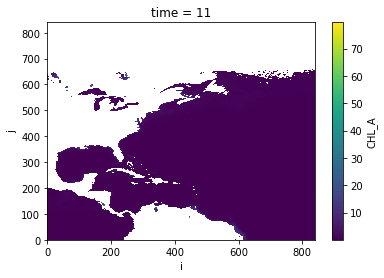

In [4]:
# we ran the code above on another machine and saved the file. Open this file up
wifs = xr.open_dataset("seawifs-clim.1997-2010.nc")

# create seawifs file by creating xarray dataset from scratch and adding extra dimensions we need
lon_list = np.append(wifs['lon'].values, (wifs['lon'].values[-1] - (wifs['lon'].values[-2] - wifs['lon'].values[-1])))
lat_list = np.append(wifs['lat'].values,wifs['lat'].values[-1] - (wifs['lat'].values[-2] - wifs['lat'].values[-1]))

# create dataset, name chlorophyll variable CHL_A as that is what MOM6 expects
seawifs = xr.Dataset({
    'CHL_A': xr.DataArray(
                data   = wifs['chlor_a'].values, 
                dims   = ['time', 'j', 'i'],
                coords = {'time': wifs.month.values,
                          'i' : np.arange(0.5,len(wifs.lon.values)+0.5,1),
                          'j' : np.arange(0.5,len(wifs.lat.values)+0.5,1)}),
        
    'lon_crnr': xr.DataArray(
                data   = lon_list, 
                dims   = ['IQ'],
                coords = {'IQ' : np.arange(0,len(wifs.lon.values)+1,1)}),
    
    'lat_crnr': xr.DataArray(
                data   = lat_list,
                dims   = ['JQ'],
                coords = {'JQ' : np.arange(0,len(wifs.lat.values)+1,1)})   
    })

# assign other coordinates
seawifs = seawifs.assign_coords(lon=("i", wifs.lon.values))
seawifs = seawifs.assign_coords(lat=("j", wifs.lat.values))
seawifs['CHL_A'][10].plot()

### Open Our Ocean Horizontal Grid and prepare for Xesmf

In [5]:
hgrid = xr.open_dataset("../gridInfo/ocean_hgrid.nc")

# create a translator so xesmf knows the names of these variables in our hgrid
mom_grid = {
    'lon': hgrid.x[1::2, 1::2],
    'lon_b': hgrid.x[::2, ::2],
    'lat': hgrid.y[1::2, 1::2],
    'lat_b': hgrid.y[::2, ::2]
}

mom_area = (hgrid.area[::2, ::2] + hgrid.area[1::2, 1::2]) + (hgrid.area[1::2, ::2] + hgrid.area[::2, 1::2])

### Flood the land cells

In [6]:
flooded = flood.flood_kara(seawifs['CHL_A'], xdim='i', ydim='j').drop('z').squeeze()

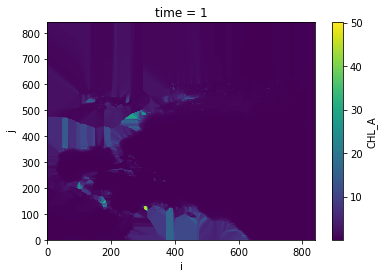

In [7]:
flooded.isel(time=0).plot()

In [8]:
# create translator so xesmf knows that names of these variables in our seawifs dataframe
seawifs_grid = {
    'lon': seawifs.lon,
    'lat': seawifs.lat,
    'lon_b': seawifs.lon_crnr,
    'lat_b': seawifs.lat_crnr
}

### Regrid using xesmf

In [ ]:
# create the regridder
seawifs_to_mom = xesmf.Regridder(seawifs_grid, mom_grid, method='conservative', reuse_weights=False)

Create weight file: conservative_840x840_1250x1500.nc


In [56]:
# regrid using our regridder generated above
regridded = seawifs_to_mom(flooded)

/Users/james/opt/anaconda3/envs/xgcmTools/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


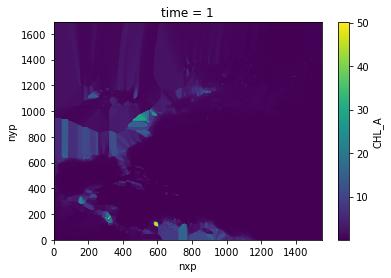

In [57]:
regridded.isel(time=0).plot()

## Tailor the file to MOM6's liking

In [107]:
# reorganize our dimensions
ds = regridded.to_dataset().transpose('time', 'nyp', 'nxp').rename({'nxp': 'xh', 'nyp': 'yh'})

# add in variables for our final file
ds['area'] = (('yh', 'xh'), mom_area.values)
ds['lon_crnr'] = (('yq', 'xq'), mom_grid['lon_b'].values)
ds['lat_crnr'] = (('yq', 'xq'), mom_grid['lat_b'].values)
ds['lon'] = (('yh', 'xh'), mom_grid['lon'].values)
ds['lat'] = (('yh', 'xh'), mom_grid['lat'].values)
ds['xh'] = (('xh'), np.arange(len(ds['xh']), dtype=np.int32))
ds['yh'] = (('yh'), np.arange(len(ds['yh']), dtype=np.int32))
ds['xh'].attrs['cartesian_axis'] = 'X'
ds['yh'].attrs['cartesian_axis'] = 'Y'

In [18]:
# Reassign time values. MOM6 is expecting a float 32 gregorian time dimension, therefore we use xarray cftime. Why the 732 hours? That's 30.5 days and roughly gives us the middle of each month
ds = ds.assign_coords(time=("time", xr.cftime_range(start=cftime.DatetimeNoLeap(1, 1, 15, 12, 0, 0, 0),end=cftime.DatetimeNoLeap(1, 12, 31, 23, 0, 0, 0), freq="732H")))
ds.time.attrs['modulo'] = ' '
ds.time.attrs['long_name'] = 'Time'
ds.time.attrs['cartesian_axis'] = 'T'

In [140]:
# update the fill value for all variables attributes
all_vars = list(ds.data_vars.keys()) + list(ds.coords.keys())
encodings = {v: {'_FillValue': None} for v in all_vars}
encodings['time'].update({'dtype':'float64'})

In [188]:
# ensure the data type is float 32 for the following variables
ds['lon'] = ds['lon'].astype(dtype='float32')
ds['lat'] = ds['lat'].astype(dtype='float32')
ds['area'] = ds['area'].astype(dtype='float32')
ds['lon_crnr'] = ds['lon_crnr'].astype(dtype='float32')
ds['lat_crnr'] = ds['lat_crnr'].astype(dtype='float32')

In [143]:
# save the file for MOM6 as `chl_mom6.nc`, as that is the default file name for this. Note that these parameters are controlled in MOM6 opacity parameters in MOM_input. 
# This file MUST be output as netcdf3! MOM6 does not like netcdf4 (as of December 2021). This file should be placed in your INPUT folder (this is the default location where MOM6 searches for the file)

ds.to_netcdf('chl_mom6.nc', 
    encoding=encodings, 
    format='NETCDF4',
    unlimited_dims='time'
)